Define TestRunner and TestPlan

In [1]:
import time
import json
import pandas as pd

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(filename)s:%(funcName)s - %(message)s',level=logging.INFO)

from elasticsearch import Elasticsearch
from clickhouse_driver import Client

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

class TestRunner:
    def __init__(self, name, config):
        self.name = name
        self.config = config
    
    def run(self, case):
        pass

class ElasticsearchRuner(TestRunner):
    def __init__(self, name, config):
        TestRunner.__init__(self, name, config)
        self.client = Elasticsearch([self.config['cluster']])
        self.indices = self.config['indices']
           
    def run(self, case):
        query = case
        
        is_aggregation = False
        if 'aggs' in query:
            is_aggregation = True
        
        logging.debug(f'{self.name} run query {case}')
        start = time.time()
        response = self.client.search(index=self.indices, body=query, scroll='10m', size=10000)
        # enable scroll when it is not an aggregation search
        if not is_aggregation:
            sid = response['_scroll_id']
            scroll_size = len(response['hits']['hits'])
            while scroll_size > 0:
                data = self.client.scroll(scroll_id=sid, scroll='2m')
                # Update the scroll ID
                sid = data['_scroll_id']
                # Get the number of results that returned in the last scroll
                scroll_size = len(data['hits']['hits'])
        end = time.time()
        logging.debug(f'{self.name} run query complete')
        
        result = {}
        result['count'] = response['hits']['total']['value']
        result['response'] = response
        result['elapsed'] = end - start
        
        logging.debug(f'query result count {result["count"]} elapsed {result["elapsed"]}')
        return result
        
class ClickhouseRuner(TestRunner):
    def __init__(self, name, config):
        TestRunner.__init__(self, name, config)
        self.client = Client(self.config['cluster'])
    
    def run(self, case):
        query = case
        logging.debug(f'{self.name} run query {case}')
        start = time.time()
        response = self.client.execute(query)
        end = time.time()
        logging.debug(f'{self.name} run query complete')
        
        result = {}
        result['count'] = len(response)
        result['response'] = response
        result['elapsed'] = end - start
        
        logging.debug(f'query result count {result["count"]} elapsed {result["elapsed"]}')
        return result
    
class TestPlan:
    def __init__(self, planfile):
        with open(planfile) as json_file:
            self.plan = json.load(json_file)
            self.targets = []
            for target in self.plan['targets']:
                if target['type'] == 'elasticsearch':
                    runner = ElasticsearchRuner(target['name'], target['config'])
                    self.targets.append(runner)
                elif target['type'] == 'clickhouse':
                    runner = ClickhouseRuner(target['name'], target['config'])
                    self.targets.append(runner)
    
    def run(self):
        reports = []
        for testcase in self.plan['testcases']:
            name, description, cases = testcase
            report = {}
            report['name'] = name
            report['description'] = description
            report['result'] = []
            logging.info(f'run testcase {name} {description}')
            tests = list(zip(self.targets, cases))
            for test in tests:
                runner, query = test
                result = {}
                result['target'] = runner.name
                result['case'] = str(query)
                
                elapsed = []
                for i in range(self.plan['runs']):
                    run_result = runner.run(query)
                    elapsed.append(run_result['elapsed'])
                    
                result['elapsed'] = elapsed
                result['elapsed_total'] = sum(elapsed)
                report['result'].append(result)
                
            logging.info(f'run testcase {name} complete')
            reports.append(report)
        return self._summary(reports), self._detail(reports)
    
    def _summary(self, reports):
        #convert reports data to dataframe
        data = {}
        columns = []

        for report in reports:
            for result in report['result']:
                if 'name' not in data:
                    data['name'] = []
                    columns.append('name')
                data['name'].append(report['name'])
                
                if 'description' not in data:
                    data['description'] = []
                    columns.append('description')
                data['description'].append(report['description'])

                if 'target' not in data:
                    data['target'] = []
                    columns.append('target')
                data['target'].append(result['target'])

                if 'elapsed_total' not in data:
                    data['elapsed_total'] = []
                    columns.append('elapsed_total')
                data['elapsed_total'].append(result['elapsed_total'])

        summary_df = pd.DataFrame (data, columns = columns)
        return summary_df
    
    def _detail(self, reports):
        data = {}
        columns = []

        for report in reports:
            for result in report['result']:
                for elapsed in result['elapsed']:
                    if 'name' not in data:
                        data['name'] = []
                        columns.append('name')
                    data['name'].append(report['name'])

                    if 'description' not in data:
                        data['description'] = []
                        columns.append('description')
                    data['description'].append(report['description'])

                    if 'target' not in data:
                        data['target'] = []
                        columns.append('target')
                    data['target'].append(result['target'])

                    if 'elapsed' not in data:
                        data['elapsed'] = []
                        columns.append('elapsed')
                    data['elapsed'].append(elapsed)

        detail_df = pd.DataFrame (data, columns = columns)
        return detail_df
        

2021-02-27 02:26:05,389 - INFO - font_manager.py:_rebuild - Generating new fontManager, this may take some time...


Sample to run a test query

In [ ]:
clickhouse_config = { "cluster" : "host.docker.internal"} 
clickhouse_runner = ClickhouseRuner('clickhouse', clickhouse_config)

query = 'SELECT * FROM syslog'
clickhouse_runner.run(query)

es_config = { "cluster" : "host.docker.internal", "indices" : "syslog-2021-02-24,syslog-2021-02-25"} 
es_runner = ElasticsearchRuner('es', es_config)

query = {
    "query": {
        "match_all": {}
    }
}
es_runner.run(query)

Run a test plan and show the test result

In [2]:
testplan = TestPlan("testplan.json")
summary_report, detail_report = testplan.run()

2021-02-27 02:26:11,223 - INFO - <ipython-input-1-626631c9da21>:run - run testcase case1 query all
2021-02-27 02:26:11,938 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.710s]
2021-02-27 02:26:12,494 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.506s]
2021-02-27 02:26:12,860 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.306s]
2021-02-27 02:26:13,215 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.298s]
2021-02-27 02:26:13,597 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.273s]
2021-02-27 02:26:13,921 - INFO - base.py:log_request_success - POST http

2021-02-27 02:26:27,188 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.239s]
2021-02-27 02:26:27,500 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.256s]
2021-02-27 02:26:27,799 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.244s]
2021-02-27 02:26:28,166 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.247s]
2021-02-27 02:26:28,465 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.243s]
2021-02-27 02:26:28,765 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.242s]
2021-02-27 02:26:29,056 - INFO - base.py:log_request_success - POST http://h

2021-02-27 02:26:41,300 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.248s]
2021-02-27 02:26:41,694 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.275s]
2021-02-27 02:26:42,001 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.251s]
2021-02-27 02:26:42,112 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.058s]
2021-02-27 02:26:42,134 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.004s]
2021-02-27 02:26:42,368 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.223s]
2021-02-27 02:26:

2021-02-27 02:26:54,856 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.285s]
2021-02-27 02:26:55,081 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.183s]
2021-02-27 02:26:55,115 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.006s]
2021-02-27 02:26:55,410 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.281s]
2021-02-27 02:26:55,676 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.180s]
2021-02-27 02:26:55,710 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scr

2021-02-27 02:27:03,968 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.041s]
2021-02-27 02:27:03,978 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.004s]
2021-02-27 02:27:04,250 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.263s]
2021-02-27 02:27:04,329 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.041s]
2021-02-27 02:27:04,341 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.005s]
2021-02-27 02:27:05,145 - INFO - <ipython-input-1-626631c9da21>:run - run testcase case4 complete
2021-02-27 02:27:05,146 - INFO - <ipython-input-1-626631c9da21>:run - run

2021-02-27 02:27:15,458 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.236s]
2021-02-27 02:27:15,753 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.238s]
2021-02-27 02:27:16,053 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.251s]
2021-02-27 02:27:16,195 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.034s]
2021-02-27 02:27:16,212 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.005s]
2021-02-27 02:27:16,457 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.234s]
2021-02-27 02:27:

2021-02-27 02:27:31,469 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.239s]
2021-02-27 02:27:31,752 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.237s]
2021-02-27 02:27:32,074 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.228s]
2021-02-27 02:27:32,353 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.230s]
2021-02-27 02:27:32,644 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.244s]
2021-02-27 02:27:32,926 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.233s]
2021-02-27 02:27:

2021-02-27 02:27:45,561 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.228s]
2021-02-27 02:27:45,848 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.227s]
2021-02-27 02:27:46,138 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.245s]
2021-02-27 02:27:46,426 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.238s]
2021-02-27 02:27:46,762 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.231s]
2021-02-27 02:27:47,057 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.248s]
2021-02-27 02:27:47,158 - INFO - base.py:log_request_success - POST http://h

2021-02-27 02:28:02,959 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.300s]
2021-02-27 02:28:03,113 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.117s]
2021-02-27 02:28:03,137 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.004s]
2021-02-27 02:28:03,405 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.258s]
2021-02-27 02:28:03,612 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scroll?scroll=2m [status:200 request:0.120s]
2021-02-27 02:28:03,635 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/_search/scr

2021-02-27 02:28:12,710 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.212s]
2021-02-27 02:28:13,048 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.237s]
2021-02-27 02:28:13,301 - INFO - base.py:log_request_success - POST http://host.docker.internal:9200/syslog-2021-02-24,syslog-2021-02-25,syslog-2021-02-26/_search?scroll=10m&size=10000 [status:200 request:0.210s]
2021-02-27 02:28:13,445 - INFO - <ipython-input-1-626631c9da21>:run - run testcase case9 complete


Detail report

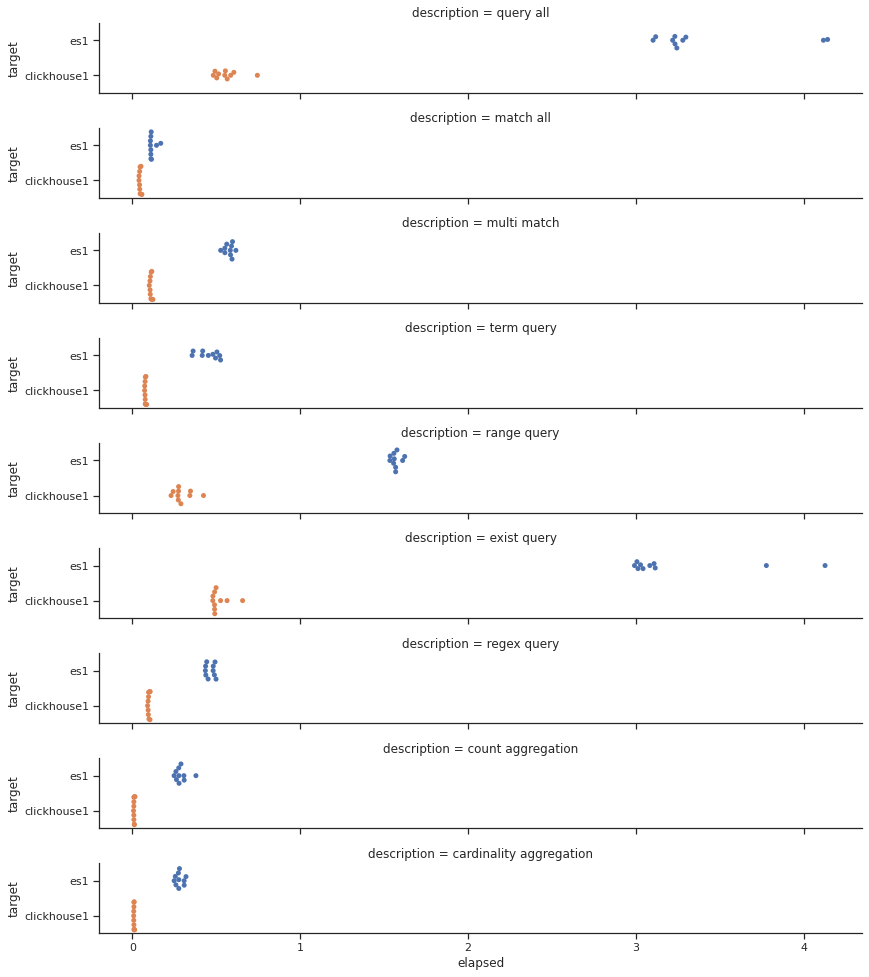

In [3]:
sns.catplot(x="elapsed", y="target", row="description", kind="swarm", 
            orient="h", height=1.5, aspect=8, 
            data=detail_report)

Summary report

<AxesSubplot:xlabel='elapsed_total', ylabel='description'>

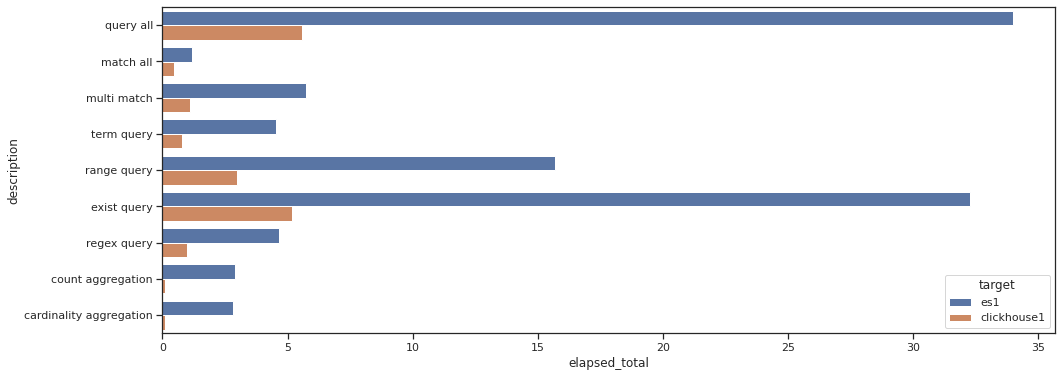

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

sns.barplot(x="elapsed_total", y="description", hue="target",data=summary_report)